In [ ]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
os.listdir('/content/drive/MyDrive/7조 조별과제/7. 기계학습_0401/카사바 kaggle data/kaggle')

['label_num_to_disease_map.json',
 'train.csv',
 'sample_submission.csv',
 'train_tfrecords',
 'test_images',
 'train_images',
 'test_tfrecords']

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/7조 조별과제/7. 기계학습_0401/카사바 kaggle data/kaggle/train.csv')
test = pd.read_csv('/content/drive/MyDrive/7조 조별과제/7. 기계학습_0401/카사바 kaggle data/kaggle/sample_submission.csv')
label_map = pd.read_json('/content/drive/MyDrive/7조 조별과제/7. 기계학습_0401/카사바 kaggle data/kaggle/label_num_to_disease_map.json', 
                         orient='index')
display(train.head())
display(test.head())
display(label_map)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


In [ ]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '/content/drive/MyDrive/7조 조별과제/7. 기계학습_0401/카사바 kaggle data/kaggle/train_images'
TEST_PATH = '/content/drive/MyDrive/7조 조별과제/7. 기계학습_0401/카사바 kaggle data/kaggle/train_images'

In [ ]:
class CFG:
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    model_name='resnet50'
    size=256
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=10
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=32
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=5
    target_col='label'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    inference=False
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [ ]:
!pip install --upgrade --force-reinstall --no-deps albumentations
!pip install timm

     |████████████████████████████████| 81kB 4.2MB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 296kB 5.3MB/s 


In [ ]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('/content/drive/MyDrive/7조 조별과제/7. 기계학습_0401/카사바 kaggle data/kaggle/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, RandomSizedCrop
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

if CFG.apex:
    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [ ]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


In [ ]:
#@title 기본 제목 텍스트
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

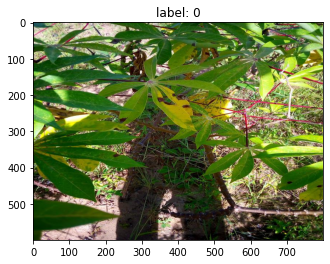

In [ ]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

In [ ]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            Resize(CFG.size, CFG.size),
            #RandomSizedCrop(CFG.size, CFG.size),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

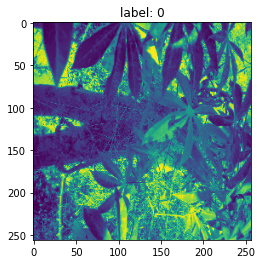

In [ ]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [ ]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnet50', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = CustomResNext(model_name=CFG.model_name, pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.1240,  0.2385, -0.0098,  0.0683,  0.1177],
        [ 0.1282,  0.1958, -0.0127,  0.0705,  0.1238],
        [ 0.2602,  0.2679, -0.0203, -0.0131,  0.0681],
        [ 0.0860,  0.3317,  0.0250, -0.0560,  0.0199]],
       grad_fn=<AddmmBackward>)


In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [ ]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [ ]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    
    if CFG.inference:
        # inference
        model = CustomResNext(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                                 num_workers=CFG.num_workers, pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

In [ ]:
if __name__ == '__main__':
    main()
    

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth


Epoch: [1][0/534] Data 9.035 (9.035) Elapsed 0m 9s (remain 86m 1s) Loss: 1.6488(1.6488) Grad: 3.6772  
Epoch: [1][100/534] Data 0.000 (1.864) Elapsed 4m 3s (remain 17m 22s) Loss: 0.4519(0.8517) Grad: 3.6595  
Epoch: [1][200/534] Data 0.000 (1.830) Elapsed 7m 57s (remain 13m 10s) Loss: 0.6567(0.7343) Grad: 6.7891  
Epoch: [1][300/534] Data 0.000 (1.822) Elapsed 11m 52s (remain 9m 11s) Loss: 0.4105(0.6764) Grad: 3.8945  
Epoch: [1][400/534] Data 0.000 (1.799) Elapsed 15m 39s (remain 5m 11s) Loss: 0.5297(0.6419) Grad: 4.9327  
Epoch: [1][500/534] Data 0.000 (1.782) Elapsed 19m 25s (remain 1m 16s) Loss: 0.3042(0.6222) Grad: 3.7055  
Epoch: [1][533/534] Data 0.000 (1.774) Elapsed 20m 38s (remain 0m 0s) Loss: 0.9503(0.6177) Grad: 6.8078  
EVAL: [0/134] Data 8.547 (8.547) Elapsed 0m 8s (remain 19m 18s) Loss: 0.5959(0.5959) 
EVAL: [100/134] Data 7.444 (2.090) Elapsed 3m 47s (remain 1m 14s) Loss: 0.5101(0.4611) 


Epoch 1 - avg_train_loss: 0.6177  avg_val_loss: 0.4634  time: 1537s
Epoch 1 - Accuracy: 0.8441588785046729
Epoch 1 - Save Best Score: 0.8442 Model


EVAL: [133/134] Data 0.000 (2.061) Elapsed 4m 57s (remain 0m 0s) Loss: 0.5612(0.4634) 
Epoch: [2][0/534] Data 1.824 (1.824) Elapsed 0m 2s (remain 21m 28s) Loss: 0.4218(0.4218) Grad: 4.2545  
Epoch: [2][100/534] Data 0.001 (0.019) Elapsed 0m 59s (remain 4m 13s) Loss: 0.4987(0.4758) Grad: 4.6404  
Epoch: [2][200/534] Data 0.000 (0.010) Elapsed 1m 55s (remain 3m 11s) Loss: 0.2330(0.4664) Grad: 2.5757  
Epoch: [2][300/534] Data 0.001 (0.007) Elapsed 2m 52s (remain 2m 13s) Loss: 0.5652(0.4566) Grad: 4.7008  
Epoch: [2][400/534] Data 0.000 (0.005) Elapsed 3m 50s (remain 1m 16s) Loss: 0.3964(0.4642) Grad: 3.5438  
Epoch: [2][500/534] Data 0.000 (0.005) Elapsed 4m 47s (remain 0m 18s) Loss: 0.3518(0.4616) Grad: 2.9130  
Epoch: [2][533/534] Data 0.000 (0.004) Elapsed 5m 6s (remain 0m 0s) Loss: 0.4228(0.4631) Grad: 3.7637  
EVAL: [0/134] Data 1.592 (1.592) Elapsed 0m 1s (remain 3m 53s) Loss: 0.6674(0.6674) 
EVAL: [100/134] Data 0.503 (0.219) Elapsed 0m 38s (remain 0m 12s) Loss: 0.4589(0.4641) 


Epoch 2 - avg_train_loss: 0.4631  avg_val_loss: 0.4607  time: 357s
Epoch 2 - Accuracy: 0.8457943925233645
Epoch 2 - Save Best Score: 0.8458 Model


EVAL: [133/134] Data 0.000 (0.211) Elapsed 0m 50s (remain 0m 0s) Loss: 0.5510(0.4607) 
Epoch: [3][0/534] Data 1.665 (1.665) Elapsed 0m 2s (remain 20m 26s) Loss: 0.4320(0.4320) Grad: 4.2901  
Epoch: [3][100/534] Data 0.002 (0.017) Elapsed 0m 59s (remain 4m 15s) Loss: 0.7679(0.3861) Grad: 6.6833  
Epoch: [3][200/534] Data 0.000 (0.009) Elapsed 1m 56s (remain 3m 13s) Loss: 0.4464(0.4089) Grad: 4.0392  
Epoch: [3][300/534] Data 0.000 (0.006) Elapsed 2m 54s (remain 2m 14s) Loss: 0.3014(0.4078) Grad: 2.9777  
Epoch: [3][400/534] Data 0.001 (0.005) Elapsed 3m 51s (remain 1m 16s) Loss: 0.4853(0.4132) Grad: 4.8031  
Epoch: [3][500/534] Data 0.000 (0.004) Elapsed 4m 48s (remain 0m 19s) Loss: 0.3555(0.4129) Grad: 4.4484  
Epoch: [3][533/534] Data 0.000 (0.004) Elapsed 5m 7s (remain 0m 0s) Loss: 0.4459(0.4139) Grad: 3.4412  
EVAL: [0/134] Data 1.434 (1.434) Elapsed 0m 1s (remain 3m 32s) Loss: 0.4783(0.4783) 
EVAL: [100/134] Data 0.390 (0.216) Elapsed 0m 38s (remain 0m 12s) Loss: 0.4400(0.4523) 


Epoch 3 - avg_train_loss: 0.4139  avg_val_loss: 0.4481  time: 358s
Epoch 3 - Accuracy: 0.8432242990654205


EVAL: [133/134] Data 0.000 (0.211) Elapsed 0m 50s (remain 0m 0s) Loss: 0.5783(0.4481) 
Epoch: [4][0/534] Data 1.669 (1.669) Elapsed 0m 2s (remain 20m 10s) Loss: 0.4117(0.4117) Grad: 4.4411  
Epoch: [4][100/534] Data 0.000 (0.018) Elapsed 0m 59s (remain 4m 17s) Loss: 0.3475(0.3734) Grad: 5.7425  
Epoch: [4][200/534] Data 0.000 (0.009) Elapsed 1m 57s (remain 3m 14s) Loss: 0.5213(0.3707) Grad: 6.8961  
Epoch: [4][300/534] Data 0.000 (0.007) Elapsed 2m 54s (remain 2m 15s) Loss: 0.4515(0.3717) Grad: 5.0876  
Epoch: [4][400/534] Data 0.004 (0.005) Elapsed 3m 52s (remain 1m 16s) Loss: 0.1873(0.3705) Grad: 2.6292  
Epoch: [4][500/534] Data 0.001 (0.004) Elapsed 4m 49s (remain 0m 19s) Loss: 0.1485(0.3742) Grad: 2.2282  
Epoch: [4][533/534] Data 0.000 (0.004) Elapsed 5m 8s (remain 0m 0s) Loss: 0.5581(0.3800) Grad: 4.6112  
EVAL: [0/134] Data 1.417 (1.417) Elapsed 0m 1s (remain 3m 30s) Loss: 0.5726(0.5726) 
EVAL: [100/134] Data 0.001 (0.221) Elapsed 0m 38s (remain 0m 12s) Loss: 0.5257(0.4148) 


Epoch 4 - avg_train_loss: 0.3800  avg_val_loss: 0.4081  time: 360s
Epoch 4 - Accuracy: 0.8619158878504672
Epoch 4 - Save Best Score: 0.8619 Model


EVAL: [133/134] Data 0.000 (0.219) Elapsed 0m 51s (remain 0m 0s) Loss: 0.4936(0.4081) 
Epoch: [5][0/534] Data 1.542 (1.542) Elapsed 0m 2s (remain 18m 43s) Loss: 0.6457(0.6457) Grad: 4.9853  
Epoch: [5][100/534] Data 0.000 (0.016) Elapsed 0m 59s (remain 4m 16s) Loss: 0.1312(0.3444) Grad: 2.3385  
Epoch: [5][200/534] Data 0.003 (0.009) Elapsed 1m 57s (remain 3m 14s) Loss: 0.6541(0.3294) Grad: 5.7406  
Epoch: [5][300/534] Data 0.000 (0.006) Elapsed 2m 54s (remain 2m 15s) Loss: 0.2223(0.3371) Grad: 3.0668  
Epoch: [5][400/534] Data 0.000 (0.005) Elapsed 3m 51s (remain 1m 16s) Loss: 0.2781(0.3414) Grad: 4.8134  
Epoch: [5][500/534] Data 0.001 (0.004) Elapsed 4m 49s (remain 0m 19s) Loss: 0.3470(0.3495) Grad: 3.6974  
Epoch: [5][533/534] Data 0.000 (0.004) Elapsed 5m 8s (remain 0m 0s) Loss: 0.4235(0.3498) Grad: 4.6152  
EVAL: [0/134] Data 1.650 (1.650) Elapsed 0m 1s (remain 4m 1s) Loss: 0.5944(0.5944) 
EVAL: [100/134] Data 0.001 (0.222) Elapsed 0m 39s (remain 0m 12s) Loss: 0.5375(0.4102) 


Epoch 5 - avg_train_loss: 0.3498  avg_val_loss: 0.4018  time: 360s
Epoch 5 - Accuracy: 0.8691588785046729
Epoch 5 - Save Best Score: 0.8692 Model


EVAL: [133/134] Data 0.000 (0.217) Elapsed 0m 51s (remain 0m 0s) Loss: 0.5884(0.4018) 
Epoch: [6][0/534] Data 1.484 (1.484) Elapsed 0m 2s (remain 18m 39s) Loss: 0.4056(0.4056) Grad: 4.3625  
Epoch: [6][100/534] Data 0.001 (0.016) Elapsed 0m 59s (remain 4m 16s) Loss: 0.2159(0.3229) Grad: 3.5710  
Epoch: [6][200/534] Data 0.003 (0.008) Elapsed 1m 57s (remain 3m 14s) Loss: 0.2485(0.3076) Grad: 3.8099  
Epoch: [6][300/534] Data 0.003 (0.006) Elapsed 2m 54s (remain 2m 15s) Loss: 0.3576(0.3173) Grad: 5.0590  
Epoch: [6][400/534] Data 0.001 (0.005) Elapsed 3m 51s (remain 1m 16s) Loss: 0.2506(0.3137) Grad: 5.2588  
Epoch: [6][500/534] Data 0.000 (0.004) Elapsed 4m 49s (remain 0m 19s) Loss: 0.4193(0.3158) Grad: 4.9026  
Epoch: [6][533/534] Data 0.000 (0.004) Elapsed 5m 8s (remain 0m 0s) Loss: 0.2107(0.3155) Grad: 3.3631  
EVAL: [0/134] Data 1.439 (1.439) Elapsed 0m 1s (remain 3m 33s) Loss: 0.5152(0.5152) 
EVAL: [100/134] Data 0.822 (0.228) Elapsed 0m 39s (remain 0m 13s) Loss: 0.5424(0.4045) 


Epoch 6 - avg_train_loss: 0.3155  avg_val_loss: 0.3990  time: 359s
Epoch 6 - Accuracy: 0.8661214953271028


EVAL: [133/134] Data 0.000 (0.214) Elapsed 0m 50s (remain 0m 0s) Loss: 0.8436(0.3990) 
Epoch: [7][0/534] Data 1.640 (1.640) Elapsed 0m 2s (remain 19m 34s) Loss: 0.2528(0.2528) Grad: 3.6597  
Epoch: [7][100/534] Data 0.000 (0.017) Elapsed 0m 59s (remain 4m 16s) Loss: 0.3425(0.2907) Grad: 5.5848  
Epoch: [7][200/534] Data 0.001 (0.009) Elapsed 1m 57s (remain 3m 14s) Loss: 0.2682(0.2816) Grad: 3.8155  
Epoch: [7][300/534] Data 0.001 (0.007) Elapsed 2m 54s (remain 2m 14s) Loss: 0.3532(0.2896) Grad: 4.8796  
Epoch: [7][400/534] Data 0.000 (0.005) Elapsed 3m 51s (remain 1m 16s) Loss: 0.1110(0.2838) Grad: 2.0703  
Epoch: [7][500/534] Data 0.000 (0.004) Elapsed 4m 49s (remain 0m 19s) Loss: 0.5400(0.2851) Grad: 5.7586  
Epoch: [7][533/534] Data 0.000 (0.004) Elapsed 5m 8s (remain 0m 0s) Loss: 0.4017(0.2855) Grad: 7.3160  
EVAL: [0/134] Data 1.686 (1.686) Elapsed 0m 1s (remain 4m 5s) Loss: 0.4565(0.4565) 
EVAL: [100/134] Data 0.857 (0.225) Elapsed 0m 39s (remain 0m 12s) Loss: 0.4201(0.3994) 


Epoch 7 - avg_train_loss: 0.2855  avg_val_loss: 0.3912  time: 359s
Epoch 7 - Accuracy: 0.8686915887850467


EVAL: [133/134] Data 0.000 (0.214) Elapsed 0m 50s (remain 0m 0s) Loss: 0.7145(0.3912) 
Epoch: [8][0/534] Data 1.698 (1.698) Elapsed 0m 2s (remain 20m 50s) Loss: 0.1546(0.1546) Grad: 3.6058  
Epoch: [8][100/534] Data 0.001 (0.018) Elapsed 0m 59s (remain 4m 16s) Loss: 0.2621(0.2627) Grad: 4.9678  
Epoch: [8][200/534] Data 0.000 (0.010) Elapsed 1m 57s (remain 3m 14s) Loss: 0.2625(0.2576) Grad: 4.2708  
Epoch: [8][300/534] Data 0.001 (0.007) Elapsed 2m 54s (remain 2m 15s) Loss: 0.2608(0.2591) Grad: 5.3193  
Epoch: [8][400/534] Data 0.001 (0.005) Elapsed 3m 52s (remain 1m 17s) Loss: 0.2131(0.2532) Grad: 3.5467  
Epoch: [8][500/534] Data 0.006 (0.005) Elapsed 4m 49s (remain 0m 19s) Loss: 0.3340(0.2484) Grad: 6.8779  
Epoch: [8][533/534] Data 0.000 (0.004) Elapsed 5m 8s (remain 0m 0s) Loss: 0.2337(0.2481) Grad: 3.7159  
EVAL: [0/134] Data 1.495 (1.495) Elapsed 0m 1s (remain 3m 42s) Loss: 0.4803(0.4803) 
EVAL: [100/134] Data 0.002 (0.217) Elapsed 0m 38s (remain 0m 12s) Loss: 0.4310(0.4073) 


Epoch 8 - avg_train_loss: 0.2481  avg_val_loss: 0.3984  time: 360s
Epoch 8 - Accuracy: 0.8705607476635514
Epoch 8 - Save Best Score: 0.8706 Model


EVAL: [133/134] Data 0.000 (0.214) Elapsed 0m 50s (remain 0m 0s) Loss: 0.8866(0.3984) 
Epoch: [9][0/534] Data 1.584 (1.584) Elapsed 0m 2s (remain 19m 32s) Loss: 0.1767(0.1767) Grad: 3.2555  
Epoch: [9][100/534] Data 0.001 (0.017) Elapsed 1m 0s (remain 4m 17s) Loss: 0.2489(0.2297) Grad: 4.9950  
Epoch: [9][200/534] Data 0.000 (0.009) Elapsed 1m 57s (remain 3m 15s) Loss: 0.2149(0.2288) Grad: 5.9301  
Epoch: [9][300/534] Data 0.002 (0.006) Elapsed 2m 55s (remain 2m 15s) Loss: 0.1556(0.2212) Grad: 3.4805  
Epoch: [9][400/534] Data 0.001 (0.005) Elapsed 3m 52s (remain 1m 17s) Loss: 0.2254(0.2174) Grad: 6.2352  
Epoch: [9][500/534] Data 0.000 (0.004) Elapsed 4m 50s (remain 0m 19s) Loss: 0.5167(0.2194) Grad: 9.7507  
Epoch: [9][533/534] Data 0.000 (0.004) Elapsed 5m 9s (remain 0m 0s) Loss: 0.1784(0.2190) Grad: 6.0226  
EVAL: [0/134] Data 1.667 (1.667) Elapsed 0m 1s (remain 4m 3s) Loss: 0.4564(0.4564) 
EVAL: [100/134] Data 0.885 (0.226) Elapsed 0m 39s (remain 0m 12s) Loss: 0.5412(0.4202) 


Epoch 9 - avg_train_loss: 0.2190  avg_val_loss: 0.4111  time: 360s
Epoch 9 - Accuracy: 0.8689252336448599


EVAL: [133/134] Data 0.000 (0.211) Elapsed 0m 50s (remain 0m 0s) Loss: 0.8553(0.4111) 
Epoch: [10][0/534] Data 1.768 (1.768) Elapsed 0m 2s (remain 20m 52s) Loss: 0.3242(0.3242) Grad: 5.8858  
Epoch: [10][100/534] Data 0.002 (0.019) Elapsed 1m 0s (remain 4m 17s) Loss: 0.2660(0.2039) Grad: 6.4364  
Epoch: [10][200/534] Data 0.001 (0.010) Elapsed 1m 57s (remain 3m 14s) Loss: 0.1209(0.1954) Grad: 3.5511  
Epoch: [10][300/534] Data 0.000 (0.007) Elapsed 2m 55s (remain 2m 15s) Loss: 0.0649(0.1999) Grad: 2.3984  
Epoch: [10][400/534] Data 0.000 (0.005) Elapsed 3m 52s (remain 1m 17s) Loss: 0.2388(0.1990) Grad: 5.4016  
Epoch: [10][500/534] Data 0.000 (0.005) Elapsed 4m 49s (remain 0m 19s) Loss: 0.2854(0.2000) Grad: 4.9667  
Epoch: [10][533/534] Data 0.000 (0.004) Elapsed 5m 8s (remain 0m 0s) Loss: 0.0781(0.2007) Grad: 3.3198  
EVAL: [0/134] Data 1.567 (1.567) Elapsed 0m 1s (remain 3m 50s) Loss: 0.4487(0.4487) 
EVAL: [100/134] Data 0.590 (0.218) Elapsed 0m 38s (remain 0m 12s) Loss: 0.4870(0.431

Epoch 10 - avg_train_loss: 0.2007  avg_val_loss: 0.4228  time: 359s
Epoch 10 - Accuracy: 0.866822429906542


EVAL: [133/134] Data 0.000 (0.209) Elapsed 0m 50s (remain 0m 0s) Loss: 0.9147(0.4228) 


========== fold: 0 result ==========
Score: 0.87056
========== fold: 1 training ==========


Epoch: [1][0/534] Data 1.559 (1.559) Elapsed 0m 2s (remain 19m 26s) Loss: 1.6591(1.6591) Grad: 3.9395  
Epoch: [1][100/534] Data 0.001 (0.017) Elapsed 1m 0s (remain 4m 18s) Loss: 0.5602(0.8830) Grad: 4.1600  
Epoch: [1][200/534] Data 0.000 (0.009) Elapsed 1m 57s (remain 3m 15s) Loss: 0.4298(0.7801) Grad: 3.1489  
Epoch: [1][300/534] Data 0.001 (0.006) Elapsed 2m 55s (remain 2m 15s) Loss: 0.5462(0.7076) Grad: 5.1722  
Epoch: [1][400/534] Data 0.001 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.5904(0.6726) Grad: 4.9820  
Epoch: [1][500/534] Data 0.000 (0.004) Elapsed 4m 50s (remain 0m 19s) Loss: 0.5136(0.6443) Grad: 4.6938  
Epoch: [1][533/534] Data 0.000 (0.004) Elapsed 5m 9s (remain 0m 0s) Loss: 0.5818(0.6354) Grad: 4.8103  
EVAL: [0/134] Data 1.364 (1.364) Elapsed 0m 1s (remain 3m 25s) Loss: 0.4723(0.4723) 
EVAL: [100/134] Data 0.874 (0.226) Elapsed 0m 39s (remain 0m 12s) Loss: 0.5306(0.4669) 


Epoch 1 - avg_train_loss: 0.6354  avg_val_loss: 0.4641  time: 360s
Epoch 1 - Accuracy: 0.8336448598130841
Epoch 1 - Save Best Score: 0.8336 Model


EVAL: [133/134] Data 0.000 (0.210) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2640(0.4641) 
Epoch: [2][0/534] Data 1.491 (1.491) Elapsed 0m 2s (remain 18m 29s) Loss: 0.4759(0.4759) Grad: 5.3057  
Epoch: [2][100/534] Data 0.002 (0.016) Elapsed 0m 59s (remain 4m 17s) Loss: 0.4009(0.4799) Grad: 3.1696  
Epoch: [2][200/534] Data 0.000 (0.008) Elapsed 1m 57s (remain 3m 14s) Loss: 0.4474(0.4796) Grad: 3.1982  
Epoch: [2][300/534] Data 0.000 (0.006) Elapsed 2m 54s (remain 2m 15s) Loss: 0.2826(0.4770) Grad: 3.6978  
Epoch: [2][400/534] Data 0.000 (0.005) Elapsed 3m 52s (remain 1m 16s) Loss: 0.8894(0.4772) Grad: 6.1005  
Epoch: [2][500/534] Data 0.000 (0.004) Elapsed 4m 49s (remain 0m 19s) Loss: 0.7988(0.4788) Grad: 6.9920  
Epoch: [2][533/534] Data 0.000 (0.004) Elapsed 5m 8s (remain 0m 0s) Loss: 0.3938(0.4780) Grad: 4.0231  
EVAL: [0/134] Data 1.639 (1.639) Elapsed 0m 1s (remain 3m 59s) Loss: 0.3908(0.3908) 
EVAL: [100/134] Data 0.856 (0.227) Elapsed 0m 39s (remain 0m 13s) Loss: 0.2713(0.4035) 


Epoch 2 - avg_train_loss: 0.4780  avg_val_loss: 0.4006  time: 360s
Epoch 2 - Accuracy: 0.860981308411215
Epoch 2 - Save Best Score: 0.8610 Model


EVAL: [133/134] Data 0.000 (0.213) Elapsed 0m 50s (remain 0m 0s) Loss: 0.1843(0.4006) 
Epoch: [3][0/534] Data 1.621 (1.621) Elapsed 0m 2s (remain 19m 37s) Loss: 0.2242(0.2242) Grad: 1.9891  
Epoch: [3][100/534] Data 0.011 (0.018) Elapsed 1m 0s (remain 4m 18s) Loss: 0.5978(0.4012) Grad: 5.6571  
Epoch: [3][200/534] Data 0.000 (0.010) Elapsed 1m 57s (remain 3m 15s) Loss: 0.2797(0.4163) Grad: 3.3816  
Epoch: [3][300/534] Data 0.001 (0.007) Elapsed 2m 55s (remain 2m 16s) Loss: 0.4034(0.4244) Grad: 3.3378  
Epoch: [3][400/534] Data 0.001 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.8689(0.4254) Grad: 5.5423  
Epoch: [3][500/534] Data 0.000 (0.005) Elapsed 4m 51s (remain 0m 19s) Loss: 0.3149(0.4219) Grad: 3.2820  
Epoch: [3][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.5234(0.4240) Grad: 4.5322  
EVAL: [0/134] Data 1.461 (1.461) Elapsed 0m 1s (remain 3m 36s) Loss: 0.2560(0.2560) 
EVAL: [100/134] Data 0.618 (0.219) Elapsed 0m 38s (remain 0m 12s) Loss: 0.2509(0.3776) 


Epoch 3 - avg_train_loss: 0.4240  avg_val_loss: 0.3767  time: 361s
Epoch 3 - Accuracy: 0.8670560747663552
Epoch 3 - Save Best Score: 0.8671 Model


EVAL: [133/134] Data 0.000 (0.211) Elapsed 0m 50s (remain 0m 0s) Loss: 0.1344(0.3767) 
Epoch: [4][0/534] Data 1.727 (1.727) Elapsed 0m 2s (remain 20m 59s) Loss: 0.3852(0.3852) Grad: 3.9666  
Epoch: [4][100/534] Data 0.000 (0.018) Elapsed 1m 0s (remain 4m 17s) Loss: 0.1578(0.3884) Grad: 2.5074  
Epoch: [4][200/534] Data 0.004 (0.010) Elapsed 1m 57s (remain 3m 14s) Loss: 0.5264(0.3915) Grad: 4.7481  
Epoch: [4][300/534] Data 0.000 (0.007) Elapsed 2m 55s (remain 2m 15s) Loss: 0.2477(0.3866) Grad: 2.4850  
Epoch: [4][400/534] Data 0.001 (0.005) Elapsed 3m 52s (remain 1m 17s) Loss: 0.2818(0.3902) Grad: 3.4312  
Epoch: [4][500/534] Data 0.000 (0.005) Elapsed 4m 50s (remain 0m 19s) Loss: 0.3553(0.3930) Grad: 3.1424  
Epoch: [4][533/534] Data 0.000 (0.004) Elapsed 5m 8s (remain 0m 0s) Loss: 0.3465(0.3920) Grad: 4.2475  
EVAL: [0/134] Data 1.431 (1.431) Elapsed 0m 1s (remain 3m 32s) Loss: 0.2162(0.2162) 
EVAL: [100/134] Data 0.000 (0.216) Elapsed 0m 38s (remain 0m 12s) Loss: 0.4420(0.3934) 


Epoch 4 - avg_train_loss: 0.3920  avg_val_loss: 0.3884  time: 359s
Epoch 4 - Accuracy: 0.8644859813084113


EVAL: [133/134] Data 0.000 (0.207) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0668(0.3884) 
Epoch: [5][0/534] Data 1.774 (1.774) Elapsed 0m 2s (remain 20m 40s) Loss: 0.4408(0.4408) Grad: 4.4117  
Epoch: [5][100/534] Data 0.001 (0.019) Elapsed 0m 59s (remain 4m 16s) Loss: 0.2582(0.3551) Grad: 3.7505  
Epoch: [5][200/534] Data 0.000 (0.010) Elapsed 1m 57s (remain 3m 14s) Loss: 0.5031(0.3584) Grad: 4.6461  
Epoch: [5][300/534] Data 0.001 (0.007) Elapsed 2m 54s (remain 2m 15s) Loss: 0.3108(0.3651) Grad: 4.0147  
Epoch: [5][400/534] Data 0.000 (0.006) Elapsed 3m 52s (remain 1m 16s) Loss: 0.3260(0.3615) Grad: 4.9188  
Epoch: [5][500/534] Data 0.000 (0.005) Elapsed 4m 49s (remain 0m 19s) Loss: 0.2887(0.3597) Grad: 3.8295  
Epoch: [5][533/534] Data 0.000 (0.004) Elapsed 5m 8s (remain 0m 0s) Loss: 0.3698(0.3617) Grad: 4.6785  
EVAL: [0/134] Data 1.483 (1.483) Elapsed 0m 1s (remain 3m 39s) Loss: 0.1989(0.1989) 
EVAL: [100/134] Data 0.119 (0.216) Elapsed 0m 38s (remain 0m 12s) Loss: 0.3040(0.3706) 


Epoch 5 - avg_train_loss: 0.3617  avg_val_loss: 0.3659  time: 359s
Epoch 5 - Accuracy: 0.872196261682243
Epoch 5 - Save Best Score: 0.8722 Model


EVAL: [133/134] Data 0.000 (0.212) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0852(0.3659) 
Epoch: [6][0/534] Data 1.675 (1.675) Elapsed 0m 2s (remain 20m 15s) Loss: 0.2639(0.2639) Grad: 3.6691  
Epoch: [6][100/534] Data 0.015 (0.018) Elapsed 0m 59s (remain 4m 15s) Loss: 0.3007(0.3061) Grad: 3.7303  
Epoch: [6][200/534] Data 0.002 (0.010) Elapsed 1m 57s (remain 3m 13s) Loss: 0.4887(0.3187) Grad: 5.0949  
Epoch: [6][300/534] Data 0.000 (0.007) Elapsed 2m 54s (remain 2m 14s) Loss: 0.3984(0.3217) Grad: 4.7420  
Epoch: [6][400/534] Data 0.001 (0.005) Elapsed 3m 51s (remain 1m 16s) Loss: 0.3258(0.3252) Grad: 4.5717  
Epoch: [6][500/534] Data 0.000 (0.005) Elapsed 4m 48s (remain 0m 19s) Loss: 0.4232(0.3239) Grad: 6.0687  
Epoch: [6][533/534] Data 0.000 (0.004) Elapsed 5m 7s (remain 0m 0s) Loss: 0.2723(0.3230) Grad: 3.3017  
EVAL: [0/134] Data 1.667 (1.667) Elapsed 0m 1s (remain 4m 3s) Loss: 0.1900(0.1900) 
EVAL: [100/134] Data 0.194 (0.224) Elapsed 0m 39s (remain 0m 12s) Loss: 0.3627(0.3725) 


Epoch 6 - avg_train_loss: 0.3230  avg_val_loss: 0.3671  time: 359s
Epoch 6 - Accuracy: 0.8719626168224299


EVAL: [133/134] Data 0.000 (0.215) Elapsed 0m 51s (remain 0m 0s) Loss: 0.0301(0.3671) 
Epoch: [7][0/534] Data 1.367 (1.367) Elapsed 0m 2s (remain 17m 59s) Loss: 0.3407(0.3407) Grad: 4.9949  
Epoch: [7][100/534] Data 0.000 (0.015) Elapsed 0m 59s (remain 4m 15s) Loss: 0.2212(0.2701) Grad: 3.0398  
Epoch: [7][200/534] Data 0.003 (0.008) Elapsed 1m 56s (remain 3m 13s) Loss: 0.3622(0.2782) Grad: 5.5812  
Epoch: [7][300/534] Data 0.000 (0.006) Elapsed 2m 54s (remain 2m 14s) Loss: 0.3220(0.2850) Grad: 4.6185  
Epoch: [7][400/534] Data 0.001 (0.004) Elapsed 3m 51s (remain 1m 16s) Loss: 0.3338(0.2884) Grad: 5.7215  
Epoch: [7][500/534] Data 0.001 (0.004) Elapsed 4m 49s (remain 0m 19s) Loss: 0.5447(0.2875) Grad: 7.3207  
Epoch: [7][533/534] Data 0.000 (0.004) Elapsed 5m 8s (remain 0m 0s) Loss: 0.2305(0.2882) Grad: 3.6312  
EVAL: [0/134] Data 1.593 (1.593) Elapsed 0m 1s (remain 3m 53s) Loss: 0.2338(0.2338) 
EVAL: [100/134] Data 0.779 (0.221) Elapsed 0m 39s (remain 0m 12s) Loss: 0.3672(0.3751) 


Epoch 7 - avg_train_loss: 0.2882  avg_val_loss: 0.3764  time: 359s
Epoch 7 - Accuracy: 0.8682242990654205


EVAL: [133/134] Data 0.000 (0.214) Elapsed 0m 51s (remain 0m 0s) Loss: 0.0419(0.3764) 
Epoch: [8][0/534] Data 1.602 (1.602) Elapsed 0m 2s (remain 19m 46s) Loss: 0.3543(0.3543) Grad: 5.6662  
Epoch: [8][100/534] Data 0.000 (0.017) Elapsed 0m 59s (remain 4m 16s) Loss: 0.1946(0.2638) Grad: 2.9258  
Epoch: [8][200/534] Data 0.001 (0.009) Elapsed 1m 57s (remain 3m 14s) Loss: 0.3014(0.2584) Grad: 6.6805  
Epoch: [8][300/534] Data 0.002 (0.006) Elapsed 2m 54s (remain 2m 15s) Loss: 0.1148(0.2554) Grad: 2.9357  
Epoch: [8][400/534] Data 0.001 (0.005) Elapsed 3m 52s (remain 1m 17s) Loss: 0.0576(0.2571) Grad: 1.3018  
Epoch: [8][500/534] Data 0.000 (0.004) Elapsed 4m 50s (remain 0m 19s) Loss: 0.2247(0.2610) Grad: 4.8735  
Epoch: [8][533/534] Data 0.000 (0.004) Elapsed 5m 9s (remain 0m 0s) Loss: 0.3490(0.2620) Grad: 4.5859  
EVAL: [0/134] Data 1.701 (1.701) Elapsed 0m 1s (remain 4m 8s) Loss: 0.2060(0.2060) 
EVAL: [100/134] Data 0.769 (0.228) Elapsed 0m 39s (remain 0m 13s) Loss: 0.2971(0.3662) 


Epoch 8 - avg_train_loss: 0.2620  avg_val_loss: 0.3650  time: 360s
Epoch 8 - Accuracy: 0.8775700934579439
Epoch 8 - Save Best Score: 0.8776 Model


EVAL: [133/134] Data 0.000 (0.213) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0290(0.3650) 
Epoch: [9][0/534] Data 1.785 (1.785) Elapsed 0m 2s (remain 21m 9s) Loss: 0.0591(0.0591) Grad: 1.9381  
Epoch: [9][100/534] Data 0.000 (0.019) Elapsed 1m 0s (remain 4m 18s) Loss: 0.2690(0.2359) Grad: 4.7774  
Epoch: [9][200/534] Data 0.001 (0.010) Elapsed 1m 57s (remain 3m 15s) Loss: 0.1310(0.2316) Grad: 3.2572  
Epoch: [9][300/534] Data 0.000 (0.007) Elapsed 2m 55s (remain 2m 16s) Loss: 0.2123(0.2333) Grad: 4.8710  
Epoch: [9][400/534] Data 0.001 (0.006) Elapsed 3m 53s (remain 1m 17s) Loss: 0.1285(0.2263) Grad: 4.2252  
Epoch: [9][500/534] Data 0.006 (0.005) Elapsed 4m 51s (remain 0m 19s) Loss: 0.4221(0.2307) Grad: 5.9764  
Epoch: [9][533/534] Data 0.000 (0.005) Elapsed 5m 10s (remain 0m 0s) Loss: 0.2293(0.2300) Grad: 5.3992  
EVAL: [0/134] Data 1.565 (1.565) Elapsed 0m 1s (remain 3m 50s) Loss: 0.2172(0.2172) 
EVAL: [100/134] Data 0.420 (0.221) Elapsed 0m 39s (remain 0m 12s) Loss: 0.4048(0.3618) 


Epoch 9 - avg_train_loss: 0.2300  avg_val_loss: 0.3611  time: 361s
Epoch 9 - Accuracy: 0.8754672897196262


EVAL: [133/134] Data 0.000 (0.213) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0158(0.3611) 
Epoch: [10][0/534] Data 1.433 (1.433) Elapsed 0m 2s (remain 18m 11s) Loss: 0.1770(0.1770) Grad: 4.6344  
Epoch: [10][100/534] Data 0.001 (0.016) Elapsed 1m 0s (remain 4m 17s) Loss: 0.3470(0.2137) Grad: 5.7079  
Epoch: [10][200/534] Data 0.000 (0.009) Elapsed 1m 57s (remain 3m 15s) Loss: 0.0465(0.2082) Grad: 1.6248  
Epoch: [10][300/534] Data 0.000 (0.006) Elapsed 2m 55s (remain 2m 15s) Loss: 0.0730(0.2070) Grad: 3.3356  
Epoch: [10][400/534] Data 0.001 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.4310(0.2082) Grad: 7.9920  
Epoch: [10][500/534] Data 0.003 (0.004) Elapsed 4m 50s (remain 0m 19s) Loss: 0.1131(0.2074) Grad: 3.0380  
Epoch: [10][533/534] Data 0.000 (0.004) Elapsed 5m 9s (remain 0m 0s) Loss: 0.3477(0.2083) Grad: 5.7497  
EVAL: [0/134] Data 1.589 (1.589) Elapsed 0m 1s (remain 3m 53s) Loss: 0.2268(0.2268) 
EVAL: [100/134] Data 0.070 (0.217) Elapsed 0m 38s (remain 0m 12s) Loss: 0.3659(0.366

Epoch 10 - avg_train_loss: 0.2083  avg_val_loss: 0.3663  time: 360s
Epoch 10 - Accuracy: 0.8794392523364486
Epoch 10 - Save Best Score: 0.8794 Model


EVAL: [133/134] Data 0.000 (0.210) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0135(0.3663) 


========== fold: 1 result ==========
Score: 0.87944
========== fold: 2 training ==========


Epoch: [1][0/534] Data 1.563 (1.563) Elapsed 0m 2s (remain 19m 38s) Loss: 1.6164(1.6164) Grad: 3.4020  
Epoch: [1][100/534] Data 0.001 (0.017) Elapsed 1m 0s (remain 4m 17s) Loss: 0.5825(0.8766) Grad: 5.3535  
Epoch: [1][200/534] Data 0.000 (0.009) Elapsed 1m 58s (remain 3m 15s) Loss: 0.6334(0.7470) Grad: 6.2504  
Epoch: [1][300/534] Data 0.001 (0.006) Elapsed 2m 55s (remain 2m 16s) Loss: 0.3325(0.6819) Grad: 3.5191  
Epoch: [1][400/534] Data 0.002 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.4218(0.6375) Grad: 2.9056  
Epoch: [1][500/534] Data 0.001 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.4267(0.6142) Grad: 4.1653  
Epoch: [1][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.5961(0.6065) Grad: 4.5635  
EVAL: [0/134] Data 1.728 (1.728) Elapsed 0m 1s (remain 4m 11s) Loss: 0.5079(0.5079) 
EVAL: [100/134] Data 0.403 (0.220) Elapsed 0m 39s (remain 0m 12s) Loss: 0.4043(0.4633) 


Epoch 1 - avg_train_loss: 0.6065  avg_val_loss: 0.4621  time: 361s
Epoch 1 - Accuracy: 0.838747370881047
Epoch 1 - Save Best Score: 0.8387 Model


EVAL: [133/134] Data 0.000 (0.211) Elapsed 0m 50s (remain 0m 0s) Loss: 0.4588(0.4621) 
Epoch: [2][0/534] Data 1.557 (1.557) Elapsed 0m 2s (remain 19m 16s) Loss: 0.4711(0.4711) Grad: 4.4297  
Epoch: [2][100/534] Data 0.000 (0.017) Elapsed 1m 0s (remain 4m 17s) Loss: 0.7117(0.4730) Grad: 6.5450  
Epoch: [2][200/534] Data 0.001 (0.009) Elapsed 1m 57s (remain 3m 15s) Loss: 0.1963(0.4654) Grad: 2.6276  
Epoch: [2][300/534] Data 0.004 (0.006) Elapsed 2m 55s (remain 2m 16s) Loss: 0.5056(0.4575) Grad: 4.9152  
Epoch: [2][400/534] Data 0.001 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.5296(0.4545) Grad: 5.4616  
Epoch: [2][500/534] Data 0.000 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.6504(0.4582) Grad: 5.3565  
Epoch: [2][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.3383(0.4550) Grad: 3.5103  
EVAL: [0/134] Data 1.700 (1.700) Elapsed 0m 1s (remain 4m 7s) Loss: 0.4751(0.4751) 
EVAL: [100/134] Data 0.846 (0.229) Elapsed 0m 40s (remain 0m 13s) Loss: 0.5090(0.4215) 


Epoch 2 - avg_train_loss: 0.4550  avg_val_loss: 0.4268  time: 362s
Epoch 2 - Accuracy: 0.8569759289553635
Epoch 2 - Save Best Score: 0.8570 Model


EVAL: [133/134] Data 0.000 (0.219) Elapsed 0m 51s (remain 0m 0s) Loss: 0.4186(0.4268) 
Epoch: [3][0/534] Data 1.875 (1.875) Elapsed 0m 2s (remain 22m 17s) Loss: 0.2209(0.2209) Grad: 3.3571  
Epoch: [3][100/534] Data 0.001 (0.020) Elapsed 1m 0s (remain 4m 20s) Loss: 0.4134(0.4201) Grad: 3.7805  
Epoch: [3][200/534] Data 0.001 (0.010) Elapsed 1m 58s (remain 3m 16s) Loss: 0.5849(0.4240) Grad: 4.6215  
Epoch: [3][300/534] Data 0.000 (0.007) Elapsed 2m 56s (remain 2m 16s) Loss: 0.4484(0.4235) Grad: 4.7316  
Epoch: [3][400/534] Data 0.002 (0.006) Elapsed 3m 54s (remain 1m 17s) Loss: 0.4114(0.4211) Grad: 4.6549  
Epoch: [3][500/534] Data 0.001 (0.005) Elapsed 4m 52s (remain 0m 19s) Loss: 0.6682(0.4222) Grad: 5.2522  
Epoch: [3][533/534] Data 0.000 (0.005) Elapsed 5m 11s (remain 0m 0s) Loss: 0.3660(0.4209) Grad: 3.9915  
EVAL: [0/134] Data 1.703 (1.703) Elapsed 0m 1s (remain 4m 8s) Loss: 0.4451(0.4451) 
EVAL: [100/134] Data 0.514 (0.228) Elapsed 0m 39s (remain 0m 13s) Loss: 0.4209(0.4129) 


Epoch 3 - avg_train_loss: 0.4209  avg_val_loss: 0.4153  time: 364s
Epoch 3 - Accuracy: 0.8590792241177845
Epoch 3 - Save Best Score: 0.8591 Model


EVAL: [133/134] Data 0.000 (0.222) Elapsed 0m 52s (remain 0m 0s) Loss: 0.5078(0.4153) 
Epoch: [4][0/534] Data 1.922 (1.922) Elapsed 0m 2s (remain 22m 31s) Loss: 0.4401(0.4401) Grad: 3.4857  
Epoch: [4][100/534] Data 0.000 (0.020) Elapsed 1m 0s (remain 4m 19s) Loss: 0.3468(0.3899) Grad: 4.3348  
Epoch: [4][200/534] Data 0.001 (0.011) Elapsed 1m 58s (remain 3m 16s) Loss: 0.3134(0.3862) Grad: 3.8903  
Epoch: [4][300/534] Data 0.000 (0.007) Elapsed 2m 56s (remain 2m 16s) Loss: 0.6694(0.3883) Grad: 7.3356  
Epoch: [4][400/534] Data 0.001 (0.006) Elapsed 3m 54s (remain 1m 17s) Loss: 0.6275(0.3842) Grad: 4.9758  
Epoch: [4][500/534] Data 0.000 (0.005) Elapsed 4m 52s (remain 0m 19s) Loss: 0.2794(0.3889) Grad: 3.3430  
Epoch: [4][533/534] Data 0.000 (0.005) Elapsed 5m 10s (remain 0m 0s) Loss: 0.1641(0.3855) Grad: 3.6814  
EVAL: [0/134] Data 1.466 (1.466) Elapsed 0m 1s (remain 3m 36s) Loss: 0.3232(0.3232) 
EVAL: [100/134] Data 0.657 (0.230) Elapsed 0m 40s (remain 0m 13s) Loss: 0.4378(0.4002) 


Epoch 4 - avg_train_loss: 0.3855  avg_val_loss: 0.4032  time: 363s
Epoch 4 - Accuracy: 0.8649217106800654
Epoch 4 - Save Best Score: 0.8649 Model


EVAL: [133/134] Data 0.000 (0.222) Elapsed 0m 52s (remain 0m 0s) Loss: 0.4051(0.4032) 
Epoch: [5][0/534] Data 1.639 (1.639) Elapsed 0m 2s (remain 19m 46s) Loss: 0.1367(0.1367) Grad: 1.9549  
Epoch: [5][100/534] Data 0.000 (0.017) Elapsed 1m 0s (remain 4m 18s) Loss: 0.4332(0.3391) Grad: 5.3237  
Epoch: [5][200/534] Data 0.000 (0.009) Elapsed 1m 58s (remain 3m 15s) Loss: 0.2031(0.3483) Grad: 2.7728  
Epoch: [5][300/534] Data 0.000 (0.007) Elapsed 2m 56s (remain 2m 16s) Loss: 0.4578(0.3486) Grad: 7.0634  
Epoch: [5][400/534] Data 0.000 (0.005) Elapsed 3m 54s (remain 1m 17s) Loss: 0.3128(0.3508) Grad: 3.7723  
Epoch: [5][500/534] Data 0.001 (0.004) Elapsed 4m 52s (remain 0m 19s) Loss: 0.5369(0.3525) Grad: 4.5868  
Epoch: [5][533/534] Data 0.000 (0.004) Elapsed 5m 11s (remain 0m 0s) Loss: 0.5430(0.3515) Grad: 4.3658  
EVAL: [0/134] Data 1.613 (1.613) Elapsed 0m 1s (remain 3m 57s) Loss: 0.3222(0.3222) 
EVAL: [100/134] Data 0.990 (0.228) Elapsed 0m 40s (remain 0m 13s) Loss: 0.5629(0.3998) 


Epoch 5 - avg_train_loss: 0.3515  avg_val_loss: 0.4038  time: 363s
Epoch 5 - Accuracy: 0.8663239074550129
Epoch 5 - Save Best Score: 0.8663 Model


EVAL: [133/134] Data 0.000 (0.217) Elapsed 0m 51s (remain 0m 0s) Loss: 0.4568(0.4038) 
Epoch: [6][0/534] Data 1.498 (1.498) Elapsed 0m 2s (remain 18m 29s) Loss: 0.3987(0.3987) Grad: 4.1445  
Epoch: [6][100/534] Data 0.001 (0.016) Elapsed 1m 0s (remain 4m 18s) Loss: 0.5044(0.3200) Grad: 5.4366  
Epoch: [6][200/534] Data 0.001 (0.009) Elapsed 1m 57s (remain 3m 15s) Loss: 0.2274(0.3066) Grad: 4.3031  
Epoch: [6][300/534] Data 0.000 (0.006) Elapsed 2m 55s (remain 2m 16s) Loss: 0.4680(0.3130) Grad: 4.8482  
Epoch: [6][400/534] Data 0.005 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.1058(0.3208) Grad: 2.0151  
Epoch: [6][500/534] Data 0.001 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.1329(0.3228) Grad: 2.3562  
Epoch: [6][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.5644(0.3230) Grad: 5.6097  
EVAL: [0/134] Data 1.538 (1.538) Elapsed 0m 1s (remain 3m 47s) Loss: 0.2845(0.2845) 
EVAL: [100/134] Data 0.394 (0.228) Elapsed 0m 39s (remain 0m 13s) Loss: 0.5547(0.3914) 


Epoch 6 - avg_train_loss: 0.3230  avg_val_loss: 0.3961  time: 363s
Epoch 6 - Accuracy: 0.8660902079925216


EVAL: [133/134] Data 0.000 (0.219) Elapsed 0m 51s (remain 0m 0s) Loss: 0.4746(0.3961) 
Epoch: [7][0/534] Data 1.683 (1.683) Elapsed 0m 2s (remain 20m 16s) Loss: 0.3698(0.3698) Grad: 3.9040  
Epoch: [7][100/534] Data 0.001 (0.018) Elapsed 1m 0s (remain 4m 19s) Loss: 0.2797(0.2870) Grad: 4.2527  
Epoch: [7][200/534] Data 0.000 (0.010) Elapsed 1m 58s (remain 3m 15s) Loss: 0.5415(0.2972) Grad: 5.4385  
Epoch: [7][300/534] Data 0.001 (0.007) Elapsed 2m 56s (remain 2m 16s) Loss: 0.1588(0.2943) Grad: 3.2880  
Epoch: [7][400/534] Data 0.003 (0.005) Elapsed 3m 54s (remain 1m 17s) Loss: 0.1538(0.2944) Grad: 3.3990  
Epoch: [7][500/534] Data 0.001 (0.005) Elapsed 4m 51s (remain 0m 19s) Loss: 0.2870(0.2918) Grad: 4.6907  
Epoch: [7][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.1319(0.2888) Grad: 2.6510  
EVAL: [0/134] Data 1.533 (1.533) Elapsed 0m 1s (remain 3m 45s) Loss: 0.3796(0.3796) 
EVAL: [100/134] Data 0.744 (0.233) Elapsed 0m 40s (remain 0m 13s) Loss: 0.4832(0.3922) 


Epoch 7 - avg_train_loss: 0.2888  avg_val_loss: 0.3990  time: 363s
Epoch 7 - Accuracy: 0.8735685907922411
Epoch 7 - Save Best Score: 0.8736 Model


EVAL: [133/134] Data 0.000 (0.222) Elapsed 0m 52s (remain 0m 0s) Loss: 0.4688(0.3990) 
Epoch: [8][0/534] Data 1.726 (1.726) Elapsed 0m 2s (remain 20m 50s) Loss: 0.2676(0.2676) Grad: 3.6641  
Epoch: [8][100/534] Data 0.000 (0.018) Elapsed 1m 0s (remain 4m 20s) Loss: 0.2875(0.2568) Grad: 4.1767  
Epoch: [8][200/534] Data 0.000 (0.010) Elapsed 1m 58s (remain 3m 16s) Loss: 0.2973(0.2633) Grad: 5.5493  
Epoch: [8][300/534] Data 0.000 (0.007) Elapsed 2m 56s (remain 2m 16s) Loss: 0.1821(0.2546) Grad: 5.9778  
Epoch: [8][400/534] Data 0.000 (0.006) Elapsed 3m 54s (remain 1m 17s) Loss: 0.1767(0.2538) Grad: 4.9681  
Epoch: [8][500/534] Data 0.000 (0.005) Elapsed 4m 52s (remain 0m 19s) Loss: 0.5847(0.2536) Grad: 7.9001  
Epoch: [8][533/534] Data 0.000 (0.005) Elapsed 5m 11s (remain 0m 0s) Loss: 0.2687(0.2508) Grad: 5.4742  
EVAL: [0/134] Data 1.552 (1.552) Elapsed 0m 1s (remain 3m 48s) Loss: 0.4542(0.4542) 
EVAL: [100/134] Data 0.917 (0.238) Elapsed 0m 40s (remain 0m 13s) Loss: 0.7304(0.4057) 


Epoch 8 - avg_train_loss: 0.2508  avg_val_loss: 0.4038  time: 364s
Epoch 8 - Accuracy: 0.8702967983173638


EVAL: [133/134] Data 0.000 (0.226) Elapsed 0m 52s (remain 0m 0s) Loss: 0.4121(0.4038) 
Epoch: [9][0/534] Data 1.723 (1.723) Elapsed 0m 2s (remain 20m 31s) Loss: 0.1323(0.1323) Grad: 4.3658  
Epoch: [9][100/534] Data 0.000 (0.018) Elapsed 1m 0s (remain 4m 19s) Loss: 0.2772(0.2322) Grad: 3.8371  
Epoch: [9][200/534] Data 0.001 (0.010) Elapsed 1m 58s (remain 3m 16s) Loss: 0.3333(0.2310) Grad: 5.1211  
Epoch: [9][300/534] Data 0.001 (0.007) Elapsed 2m 56s (remain 2m 16s) Loss: 0.1799(0.2273) Grad: 4.4927  
Epoch: [9][400/534] Data 0.001 (0.006) Elapsed 3m 54s (remain 1m 17s) Loss: 0.1869(0.2215) Grad: 4.9659  
Epoch: [9][500/534] Data 0.000 (0.005) Elapsed 4m 52s (remain 0m 19s) Loss: 0.1478(0.2224) Grad: 3.8138  
Epoch: [9][533/534] Data 0.000 (0.004) Elapsed 5m 11s (remain 0m 0s) Loss: 0.1955(0.2229) Grad: 5.1227  
EVAL: [0/134] Data 1.670 (1.670) Elapsed 0m 1s (remain 4m 3s) Loss: 0.3992(0.3992) 
EVAL: [100/134] Data 0.688 (0.230) Elapsed 0m 40s (remain 0m 13s) Loss: 0.5642(0.4103) 


Epoch 9 - avg_train_loss: 0.2229  avg_val_loss: 0.4134  time: 364s
Epoch 9 - Accuracy: 0.87333489132975


EVAL: [133/134] Data 0.000 (0.222) Elapsed 0m 52s (remain 0m 0s) Loss: 0.4523(0.4134) 
Epoch: [10][0/534] Data 1.751 (1.751) Elapsed 0m 2s (remain 20m 54s) Loss: 0.1059(0.1059) Grad: 3.4202  
Epoch: [10][100/534] Data 0.001 (0.019) Elapsed 1m 0s (remain 4m 19s) Loss: 0.0609(0.2249) Grad: 2.3594  
Epoch: [10][200/534] Data 0.000 (0.010) Elapsed 1m 58s (remain 3m 16s) Loss: 0.2136(0.2132) Grad: 4.4801  
Epoch: [10][300/534] Data 0.001 (0.007) Elapsed 2m 56s (remain 2m 16s) Loss: 0.1216(0.2095) Grad: 3.5204  
Epoch: [10][400/534] Data 0.000 (0.005) Elapsed 3m 54s (remain 1m 17s) Loss: 0.2457(0.2028) Grad: 6.2306  
Epoch: [10][500/534] Data 0.000 (0.005) Elapsed 4m 52s (remain 0m 19s) Loss: 0.0719(0.2031) Grad: 2.9412  
Epoch: [10][533/534] Data 0.000 (0.004) Elapsed 5m 11s (remain 0m 0s) Loss: 0.1527(0.2026) Grad: 4.0978  
EVAL: [0/134] Data 1.718 (1.718) Elapsed 0m 1s (remain 4m 10s) Loss: 0.4245(0.4245) 
EVAL: [100/134] Data 0.933 (0.234) Elapsed 0m 40s (remain 0m 13s) Loss: 0.5573(0.40

Epoch 10 - avg_train_loss: 0.2026  avg_val_loss: 0.4043  time: 363s
Epoch 10 - Accuracy: 0.8749707875671886
Epoch 10 - Save Best Score: 0.8750 Model


EVAL: [133/134] Data 0.000 (0.221) Elapsed 0m 52s (remain 0m 0s) Loss: 0.4377(0.4043) 


========== fold: 2 result ==========
Score: 0.87497
========== fold: 3 training ==========


Epoch: [1][0/534] Data 1.645 (1.645) Elapsed 0m 2s (remain 20m 30s) Loss: 1.6051(1.6051) Grad: 3.5033  
Epoch: [1][100/534] Data 0.001 (0.017) Elapsed 1m 0s (remain 4m 19s) Loss: 0.5907(0.8553) Grad: 4.8717  
Epoch: [1][200/534] Data 0.004 (0.009) Elapsed 1m 58s (remain 3m 16s) Loss: 0.8811(0.7248) Grad: 8.1710  
Epoch: [1][300/534] Data 0.001 (0.007) Elapsed 2m 56s (remain 2m 16s) Loss: 0.4640(0.6615) Grad: 4.2299  
Epoch: [1][400/534] Data 0.000 (0.005) Elapsed 3m 54s (remain 1m 17s) Loss: 0.4063(0.6265) Grad: 4.2637  
Epoch: [1][500/534] Data 0.000 (0.004) Elapsed 4m 52s (remain 0m 19s) Loss: 0.6663(0.6074) Grad: 8.0323  
Epoch: [1][533/534] Data 0.000 (0.004) Elapsed 5m 11s (remain 0m 0s) Loss: 0.3571(0.5993) Grad: 2.9047  
EVAL: [0/134] Data 1.504 (1.504) Elapsed 0m 1s (remain 3m 41s) Loss: 0.7989(0.7989) 
EVAL: [100/134] Data 0.847 (0.231) Elapsed 0m 40s (remain 0m 13s) Loss: 0.3909(0.4887) 


Epoch 1 - avg_train_loss: 0.5993  avg_val_loss: 0.4908  time: 362s
Epoch 1 - Accuracy: 0.8310352886188361
Epoch 1 - Save Best Score: 0.8310 Model


EVAL: [133/134] Data 0.000 (0.215) Elapsed 0m 51s (remain 0m 0s) Loss: 0.5303(0.4908) 
Epoch: [2][0/534] Data 1.602 (1.602) Elapsed 0m 2s (remain 19m 34s) Loss: 0.4072(0.4072) Grad: 3.4035  
Epoch: [2][100/534] Data 0.000 (0.017) Elapsed 1m 0s (remain 4m 18s) Loss: 0.3514(0.4602) Grad: 3.2369  
Epoch: [2][200/534] Data 0.001 (0.009) Elapsed 1m 57s (remain 3m 15s) Loss: 0.3961(0.4597) Grad: 4.8200  
Epoch: [2][300/534] Data 0.001 (0.006) Elapsed 2m 55s (remain 2m 16s) Loss: 0.3086(0.4546) Grad: 3.9106  
Epoch: [2][400/534] Data 0.000 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.2003(0.4521) Grad: 2.2643  
Epoch: [2][500/534] Data 0.001 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.5119(0.4512) Grad: 5.1237  
Epoch: [2][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.4375(0.4515) Grad: 3.2163  
EVAL: [0/134] Data 1.677 (1.677) Elapsed 0m 1s (remain 4m 5s) Loss: 0.4952(0.4952) 
EVAL: [100/134] Data 0.005 (0.228) Elapsed 0m 39s (remain 0m 13s) Loss: 0.4328(0.4718) 


Epoch 2 - avg_train_loss: 0.4515  avg_val_loss: 0.4707  time: 363s
Epoch 2 - Accuracy: 0.8361766767936434
Epoch 2 - Save Best Score: 0.8362 Model


EVAL: [133/134] Data 0.000 (0.224) Elapsed 0m 52s (remain 0m 0s) Loss: 0.3754(0.4707) 
Epoch: [3][0/534] Data 1.753 (1.753) Elapsed 0m 2s (remain 21m 25s) Loss: 0.4682(0.4682) Grad: 4.1679  
Epoch: [3][100/534] Data 0.004 (0.019) Elapsed 1m 0s (remain 4m 18s) Loss: 0.4513(0.4166) Grad: 4.2869  
Epoch: [3][200/534] Data 0.001 (0.010) Elapsed 1m 58s (remain 3m 15s) Loss: 0.3295(0.4068) Grad: 4.8455  
Epoch: [3][300/534] Data 0.000 (0.007) Elapsed 2m 56s (remain 2m 16s) Loss: 0.6518(0.4025) Grad: 5.6699  
Epoch: [3][400/534] Data 0.000 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.4255(0.4039) Grad: 4.9073  
Epoch: [3][500/534] Data 0.001 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.4154(0.4075) Grad: 3.5793  
Epoch: [3][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.7817(0.4104) Grad: 5.3074  
EVAL: [0/134] Data 1.599 (1.599) Elapsed 0m 1s (remain 3m 54s) Loss: 0.6260(0.6260) 
EVAL: [100/134] Data 0.685 (0.221) Elapsed 0m 39s (remain 0m 12s) Loss: 0.2720(0.4342) 


Epoch 3 - avg_train_loss: 0.4104  avg_val_loss: 0.4359  time: 361s
Epoch 3 - Accuracy: 0.8443561579808366
Epoch 3 - Save Best Score: 0.8444 Model


EVAL: [133/134] Data 0.000 (0.210) Elapsed 0m 50s (remain 0m 0s) Loss: 0.3391(0.4359) 
Epoch: [4][0/534] Data 1.679 (1.679) Elapsed 0m 2s (remain 20m 16s) Loss: 0.2028(0.2028) Grad: 3.4979  
Epoch: [4][100/534] Data 0.002 (0.017) Elapsed 1m 0s (remain 4m 17s) Loss: 0.1820(0.3730) Grad: 2.5322  
Epoch: [4][200/534] Data 0.000 (0.009) Elapsed 1m 57s (remain 3m 15s) Loss: 0.2228(0.3638) Grad: 3.0745  
Epoch: [4][300/534] Data 0.000 (0.007) Elapsed 2m 55s (remain 2m 15s) Loss: 0.4269(0.3753) Grad: 4.6910  
Epoch: [4][400/534] Data 0.000 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.3278(0.3732) Grad: 4.8516  
Epoch: [4][500/534] Data 0.001 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.4530(0.3761) Grad: 5.2578  
Epoch: [4][533/534] Data 0.000 (0.004) Elapsed 5m 9s (remain 0m 0s) Loss: 0.5258(0.3778) Grad: 4.3985  
EVAL: [0/134] Data 1.594 (1.594) Elapsed 0m 1s (remain 3m 53s) Loss: 0.5860(0.5860) 
EVAL: [100/134] Data 0.802 (0.225) Elapsed 0m 39s (remain 0m 12s) Loss: 0.2878(0.4314) 


Epoch 4 - avg_train_loss: 0.3778  avg_val_loss: 0.4265  time: 361s
Epoch 4 - Accuracy: 0.8551063332554335
Epoch 4 - Save Best Score: 0.8551 Model


EVAL: [133/134] Data 0.000 (0.213) Elapsed 0m 50s (remain 0m 0s) Loss: 0.3757(0.4265) 
Epoch: [5][0/534] Data 1.721 (1.721) Elapsed 0m 2s (remain 20m 44s) Loss: 0.2731(0.2731) Grad: 4.1148  
Epoch: [5][100/534] Data 0.001 (0.018) Elapsed 1m 0s (remain 4m 17s) Loss: 0.5408(0.3297) Grad: 5.7477  
Epoch: [5][200/534] Data 0.001 (0.010) Elapsed 1m 57s (remain 3m 15s) Loss: 0.2866(0.3352) Grad: 4.4392  
Epoch: [5][300/534] Data 0.000 (0.007) Elapsed 2m 55s (remain 2m 15s) Loss: 0.6930(0.3524) Grad: 5.1370  
Epoch: [5][400/534] Data 0.001 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.2507(0.3497) Grad: 4.5938  
Epoch: [5][500/534] Data 0.000 (0.005) Elapsed 4m 51s (remain 0m 19s) Loss: 0.2450(0.3482) Grad: 4.8254  
Epoch: [5][533/534] Data 0.000 (0.004) Elapsed 5m 9s (remain 0m 0s) Loss: 0.1651(0.3484) Grad: 2.9315  
EVAL: [0/134] Data 1.446 (1.446) Elapsed 0m 1s (remain 3m 34s) Loss: 0.6408(0.6408) 
EVAL: [100/134] Data 0.304 (0.220) Elapsed 0m 39s (remain 0m 12s) Loss: 0.3043(0.4192) 


Epoch 5 - avg_train_loss: 0.3484  avg_val_loss: 0.4184  time: 361s
Epoch 5 - Accuracy: 0.8553400327179248
Epoch 5 - Save Best Score: 0.8553 Model


EVAL: [133/134] Data 0.000 (0.214) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2705(0.4184) 
Epoch: [6][0/534] Data 1.658 (1.658) Elapsed 0m 2s (remain 20m 13s) Loss: 0.2516(0.2516) Grad: 3.8051  
Epoch: [6][100/534] Data 0.001 (0.017) Elapsed 1m 0s (remain 4m 18s) Loss: 0.1395(0.3134) Grad: 2.6232  
Epoch: [6][200/534] Data 0.001 (0.009) Elapsed 1m 57s (remain 3m 15s) Loss: 0.4266(0.3112) Grad: 5.1750  
Epoch: [6][300/534] Data 0.000 (0.006) Elapsed 2m 55s (remain 2m 15s) Loss: 0.3880(0.3112) Grad: 4.9908  
Epoch: [6][400/534] Data 0.001 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.3484(0.3084) Grad: 3.4629  
Epoch: [6][500/534] Data 0.003 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.3412(0.3102) Grad: 4.2838  
Epoch: [6][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.1438(0.3130) Grad: 2.3058  
EVAL: [0/134] Data 1.599 (1.599) Elapsed 0m 1s (remain 3m 55s) Loss: 0.6380(0.6380) 
EVAL: [100/134] Data 0.621 (0.227) Elapsed 0m 39s (remain 0m 12s) Loss: 0.3012(0.4227) 


Epoch 6 - avg_train_loss: 0.3130  avg_val_loss: 0.4192  time: 361s
Epoch 6 - Accuracy: 0.8609488198177144
Epoch 6 - Save Best Score: 0.8609 Model


EVAL: [133/134] Data 0.000 (0.215) Elapsed 0m 51s (remain 0m 0s) Loss: 0.4187(0.4192) 
Epoch: [7][0/534] Data 1.647 (1.647) Elapsed 0m 2s (remain 20m 1s) Loss: 0.2966(0.2966) Grad: 3.8212  
Epoch: [7][100/534] Data 0.000 (0.018) Elapsed 1m 0s (remain 4m 18s) Loss: 0.2042(0.2868) Grad: 3.3779  
Epoch: [7][200/534] Data 0.001 (0.009) Elapsed 1m 57s (remain 3m 15s) Loss: 0.4013(0.2874) Grad: 5.5630  
Epoch: [7][300/534] Data 0.000 (0.007) Elapsed 2m 55s (remain 2m 16s) Loss: 0.1845(0.2859) Grad: 2.4900  
Epoch: [7][400/534] Data 0.000 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.4536(0.2851) Grad: 6.4803  
Epoch: [7][500/534] Data 0.000 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.3235(0.2845) Grad: 5.6221  
Epoch: [7][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.1269(0.2836) Grad: 2.6463  
EVAL: [0/134] Data 1.685 (1.685) Elapsed 0m 1s (remain 4m 9s) Loss: 0.5980(0.5980) 
EVAL: [100/134] Data 0.210 (0.223) Elapsed 0m 39s (remain 0m 12s) Loss: 0.4219(0.4229) 


Epoch 7 - avg_train_loss: 0.2836  avg_val_loss: 0.4212  time: 361s
Epoch 7 - Accuracy: 0.8637532133676092
Epoch 7 - Save Best Score: 0.8638 Model


EVAL: [133/134] Data 0.000 (0.216) Elapsed 0m 51s (remain 0m 0s) Loss: 0.2627(0.4212) 
Epoch: [8][0/534] Data 1.754 (1.754) Elapsed 0m 2s (remain 21m 3s) Loss: 0.2086(0.2086) Grad: 3.4248  
Epoch: [8][100/534] Data 0.000 (0.018) Elapsed 1m 0s (remain 4m 18s) Loss: 0.3365(0.2521) Grad: 7.1765  
Epoch: [8][200/534] Data 0.000 (0.010) Elapsed 1m 57s (remain 3m 15s) Loss: 0.2689(0.2438) Grad: 4.6211  
Epoch: [8][300/534] Data 0.000 (0.007) Elapsed 2m 55s (remain 2m 15s) Loss: 0.2162(0.2462) Grad: 5.0014  
Epoch: [8][400/534] Data 0.000 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.1361(0.2506) Grad: 3.4763  
Epoch: [8][500/534] Data 0.000 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.3557(0.2491) Grad: 6.3273  
Epoch: [8][533/534] Data 0.000 (0.004) Elapsed 5m 9s (remain 0m 0s) Loss: 0.3829(0.2486) Grad: 5.4154  
EVAL: [0/134] Data 1.756 (1.756) Elapsed 0m 1s (remain 4m 15s) Loss: 0.6273(0.6273) 
EVAL: [100/134] Data 0.904 (0.222) Elapsed 0m 39s (remain 0m 12s) Loss: 0.3598(0.4298) 


Epoch 8 - avg_train_loss: 0.2486  avg_val_loss: 0.4258  time: 361s
Epoch 8 - Accuracy: 0.8637532133676092


EVAL: [133/134] Data 0.005 (0.209) Elapsed 0m 50s (remain 0m 0s) Loss: 0.4694(0.4258) 
Epoch: [9][0/534] Data 1.726 (1.726) Elapsed 0m 2s (remain 20m 47s) Loss: 0.1843(0.1843) Grad: 3.9225  
Epoch: [9][100/534] Data 0.002 (0.018) Elapsed 1m 0s (remain 4m 18s) Loss: 0.0577(0.2133) Grad: 1.3452  
Epoch: [9][200/534] Data 0.001 (0.010) Elapsed 1m 57s (remain 3m 15s) Loss: 0.2058(0.2136) Grad: 3.4423  
Epoch: [9][300/534] Data 0.000 (0.007) Elapsed 2m 55s (remain 2m 15s) Loss: 0.1472(0.2158) Grad: 4.6391  
Epoch: [9][400/534] Data 0.002 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.2202(0.2195) Grad: 4.6112  
Epoch: [9][500/534] Data 0.001 (0.005) Elapsed 4m 51s (remain 0m 19s) Loss: 0.2007(0.2185) Grad: 4.4879  
Epoch: [9][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.1600(0.2180) Grad: 5.3357  
EVAL: [0/134] Data 1.574 (1.574) Elapsed 0m 1s (remain 3m 51s) Loss: 0.7256(0.7256) 
EVAL: [100/134] Data 0.643 (0.222) Elapsed 0m 39s (remain 0m 12s) Loss: 0.4392(0.4413) 


Epoch 9 - avg_train_loss: 0.2180  avg_val_loss: 0.4392  time: 361s
Epoch 9 - Accuracy: 0.8621173171301706


EVAL: [133/134] Data 0.000 (0.210) Elapsed 0m 50s (remain 0m 0s) Loss: 0.3794(0.4392) 
Epoch: [10][0/534] Data 1.709 (1.709) Elapsed 0m 2s (remain 20m 47s) Loss: 0.3509(0.3509) Grad: 4.9708  
Epoch: [10][100/534] Data 0.000 (0.018) Elapsed 1m 0s (remain 4m 18s) Loss: 0.3411(0.2016) Grad: 4.9407  
Epoch: [10][200/534] Data 0.001 (0.010) Elapsed 1m 57s (remain 3m 15s) Loss: 0.1449(0.2056) Grad: 4.1722  
Epoch: [10][300/534] Data 0.001 (0.007) Elapsed 2m 55s (remain 2m 16s) Loss: 0.1460(0.2062) Grad: 3.6289  
Epoch: [10][400/534] Data 0.001 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.1784(0.2025) Grad: 3.6749  
Epoch: [10][500/534] Data 0.002 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.1747(0.2062) Grad: 5.7353  
Epoch: [10][533/534] Data 0.000 (0.004) Elapsed 5m 9s (remain 0m 0s) Loss: 0.0815(0.2048) Grad: 2.7090  
EVAL: [0/134] Data 1.641 (1.641) Elapsed 0m 1s (remain 4m 0s) Loss: 0.7354(0.7354) 
EVAL: [100/134] Data 0.425 (0.220) Elapsed 0m 39s (remain 0m 12s) Loss: 0.4084(0.4419

Epoch 10 - avg_train_loss: 0.2048  avg_val_loss: 0.4408  time: 361s
Epoch 10 - Accuracy: 0.8618836176676794


EVAL: [133/134] Data 0.000 (0.210) Elapsed 0m 50s (remain 0m 0s) Loss: 0.3466(0.4408) 


========== fold: 3 result ==========
Score: 0.86375
========== fold: 4 training ==========


Epoch: [1][0/534] Data 1.741 (1.741) Elapsed 0m 2s (remain 21m 29s) Loss: 1.5536(1.5536) Grad: 3.2609  
Epoch: [1][100/534] Data 0.000 (0.018) Elapsed 1m 0s (remain 4m 18s) Loss: 0.8896(0.8530) Grad: 6.7442  
Epoch: [1][200/534] Data 0.000 (0.010) Elapsed 1m 58s (remain 3m 15s) Loss: 0.6336(0.7347) Grad: 6.6479  
Epoch: [1][300/534] Data 0.001 (0.007) Elapsed 2m 55s (remain 2m 16s) Loss: 0.4177(0.6748) Grad: 4.4954  
Epoch: [1][400/534] Data 0.000 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.7108(0.6393) Grad: 8.6522  
Epoch: [1][500/534] Data 0.001 (0.005) Elapsed 4m 51s (remain 0m 19s) Loss: 0.4417(0.6207) Grad: 4.2179  
Epoch: [1][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.7471(0.6124) Grad: 5.4617  
EVAL: [0/134] Data 1.637 (1.637) Elapsed 0m 1s (remain 3m 59s) Loss: 0.5415(0.5415) 
EVAL: [100/134] Data 0.673 (0.225) Elapsed 0m 39s (remain 0m 12s) Loss: 0.6333(0.4977) 


Epoch 1 - avg_train_loss: 0.6124  avg_val_loss: 0.4975  time: 361s
Epoch 1 - Accuracy: 0.8198177144192569
Epoch 1 - Save Best Score: 0.8198 Model


EVAL: [133/134] Data 0.000 (0.211) Elapsed 0m 50s (remain 0m 0s) Loss: 0.3976(0.4975) 
Epoch: [2][0/534] Data 1.508 (1.508) Elapsed 0m 2s (remain 18m 23s) Loss: 0.4201(0.4201) Grad: 3.9935  
Epoch: [2][100/534] Data 0.003 (0.016) Elapsed 1m 0s (remain 4m 18s) Loss: 0.4615(0.4838) Grad: 4.9379  
Epoch: [2][200/534] Data 0.000 (0.009) Elapsed 1m 58s (remain 3m 15s) Loss: 0.2439(0.4722) Grad: 2.1084  
Epoch: [2][300/534] Data 0.001 (0.006) Elapsed 2m 55s (remain 2m 15s) Loss: 0.5481(0.4721) Grad: 4.7523  
Epoch: [2][400/534] Data 0.000 (0.005) Elapsed 3m 52s (remain 1m 17s) Loss: 0.2594(0.4701) Grad: 2.6953  
Epoch: [2][500/534] Data 0.000 (0.004) Elapsed 4m 50s (remain 0m 19s) Loss: 0.5467(0.4633) Grad: 4.1047  
Epoch: [2][533/534] Data 0.000 (0.004) Elapsed 5m 9s (remain 0m 0s) Loss: 0.2883(0.4624) Grad: 5.8710  
EVAL: [0/134] Data 1.811 (1.811) Elapsed 0m 1s (remain 4m 23s) Loss: 0.6192(0.6192) 
EVAL: [100/134] Data 0.830 (0.220) Elapsed 0m 39s (remain 0m 12s) Loss: 0.4576(0.4362) 


Epoch 2 - avg_train_loss: 0.4624  avg_val_loss: 0.4319  time: 360s
Epoch 2 - Accuracy: 0.851600841318065
Epoch 2 - Save Best Score: 0.8516 Model


EVAL: [133/134] Data 0.000 (0.209) Elapsed 0m 50s (remain 0m 0s) Loss: 0.3087(0.4319) 
Epoch: [3][0/534] Data 1.608 (1.608) Elapsed 0m 2s (remain 19m 24s) Loss: 0.4058(0.4058) Grad: 3.7129  
Epoch: [3][100/534] Data 0.000 (0.017) Elapsed 1m 0s (remain 4m 17s) Loss: 0.2174(0.4017) Grad: 3.2434  
Epoch: [3][200/534] Data 0.001 (0.009) Elapsed 1m 57s (remain 3m 15s) Loss: 0.3360(0.4050) Grad: 3.4649  
Epoch: [3][300/534] Data 0.001 (0.006) Elapsed 2m 55s (remain 2m 15s) Loss: 0.3158(0.4112) Grad: 4.3371  
Epoch: [3][400/534] Data 0.000 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.3455(0.4148) Grad: 2.8482  
Epoch: [3][500/534] Data 0.007 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.4340(0.4177) Grad: 5.4286  
Epoch: [3][533/534] Data 0.000 (0.004) Elapsed 5m 9s (remain 0m 0s) Loss: 0.4563(0.4185) Grad: 4.3138  
EVAL: [0/134] Data 1.722 (1.722) Elapsed 0m 1s (remain 4m 11s) Loss: 0.4941(0.4941) 
EVAL: [100/134] Data 0.891 (0.220) Elapsed 0m 39s (remain 0m 12s) Loss: 0.4570(0.4086) 


Epoch 3 - avg_train_loss: 0.4185  avg_val_loss: 0.4147  time: 360s
Epoch 3 - Accuracy: 0.856508530030381
Epoch 3 - Save Best Score: 0.8565 Model


EVAL: [133/134] Data 0.000 (0.208) Elapsed 0m 50s (remain 0m 0s) Loss: 0.1851(0.4147) 
Epoch: [4][0/534] Data 1.850 (1.850) Elapsed 0m 2s (remain 21m 45s) Loss: 0.4199(0.4199) Grad: 3.8731  
Epoch: [4][100/534] Data 0.001 (0.020) Elapsed 1m 0s (remain 4m 19s) Loss: 0.6728(0.3934) Grad: 5.6898  
Epoch: [4][200/534] Data 0.001 (0.010) Elapsed 1m 58s (remain 3m 15s) Loss: 0.1432(0.3853) Grad: 1.8755  
Epoch: [4][300/534] Data 0.000 (0.007) Elapsed 2m 55s (remain 2m 16s) Loss: 0.3499(0.3844) Grad: 4.3062  
Epoch: [4][400/534] Data 0.000 (0.006) Elapsed 3m 53s (remain 1m 17s) Loss: 0.3328(0.3906) Grad: 3.5736  
Epoch: [4][500/534] Data 0.000 (0.005) Elapsed 4m 50s (remain 0m 19s) Loss: 0.3638(0.3866) Grad: 4.1041  
Epoch: [4][533/534] Data 0.000 (0.004) Elapsed 5m 9s (remain 0m 0s) Loss: 0.4115(0.3862) Grad: 4.9836  
EVAL: [0/134] Data 1.347 (1.347) Elapsed 0m 1s (remain 3m 21s) Loss: 0.4621(0.4621) 
EVAL: [100/134] Data 0.558 (0.218) Elapsed 0m 38s (remain 0m 12s) Loss: 0.3204(0.3914) 


Epoch 4 - avg_train_loss: 0.3862  avg_val_loss: 0.3957  time: 360s
Epoch 4 - Accuracy: 0.8639869128301005
Epoch 4 - Save Best Score: 0.8640 Model


EVAL: [133/134] Data 0.000 (0.208) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2650(0.3957) 
Epoch: [5][0/534] Data 1.858 (1.858) Elapsed 0m 2s (remain 21m 57s) Loss: 0.4218(0.4218) Grad: 4.7620  
Epoch: [5][100/534] Data 0.000 (0.019) Elapsed 1m 0s (remain 4m 19s) Loss: 0.4139(0.3623) Grad: 4.2454  
Epoch: [5][200/534] Data 0.002 (0.010) Elapsed 1m 58s (remain 3m 15s) Loss: 0.7114(0.3518) Grad: 6.1360  
Epoch: [5][300/534] Data 0.000 (0.007) Elapsed 2m 56s (remain 2m 16s) Loss: 0.4434(0.3561) Grad: 5.0967  
Epoch: [5][400/534] Data 0.001 (0.006) Elapsed 3m 53s (remain 1m 17s) Loss: 0.3198(0.3545) Grad: 5.1774  
Epoch: [5][500/534] Data 0.000 (0.005) Elapsed 4m 51s (remain 0m 19s) Loss: 0.3741(0.3579) Grad: 3.9746  
Epoch: [5][533/534] Data 0.000 (0.005) Elapsed 5m 10s (remain 0m 0s) Loss: 0.3357(0.3581) Grad: 4.0894  
EVAL: [0/134] Data 1.728 (1.728) Elapsed 0m 1s (remain 4m 11s) Loss: 0.3136(0.3136) 
EVAL: [100/134] Data 0.760 (0.231) Elapsed 0m 40s (remain 0m 13s) Loss: 0.5391(0.4352) 


Epoch 5 - avg_train_loss: 0.3581  avg_val_loss: 0.4312  time: 362s
Epoch 5 - Accuracy: 0.8464594531432578


EVAL: [133/134] Data 0.000 (0.215) Elapsed 0m 51s (remain 0m 0s) Loss: 0.2152(0.4312) 
Epoch: [6][0/534] Data 1.559 (1.559) Elapsed 0m 2s (remain 19m 32s) Loss: 0.2631(0.2631) Grad: 3.3499  
Epoch: [6][100/534] Data 0.001 (0.017) Elapsed 1m 0s (remain 4m 18s) Loss: 0.5722(0.3170) Grad: 5.9604  
Epoch: [6][200/534] Data 0.000 (0.009) Elapsed 1m 58s (remain 3m 15s) Loss: 0.3945(0.3191) Grad: 4.1016  
Epoch: [6][300/534] Data 0.000 (0.006) Elapsed 2m 55s (remain 2m 16s) Loss: 0.3961(0.3230) Grad: 5.0640  
Epoch: [6][400/534] Data 0.000 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.3274(0.3195) Grad: 5.3508  
Epoch: [6][500/534] Data 0.000 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.3389(0.3250) Grad: 4.6471  
Epoch: [6][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.3728(0.3242) Grad: 3.2641  
EVAL: [0/134] Data 1.609 (1.609) Elapsed 0m 1s (remain 3m 56s) Loss: 0.3942(0.3942) 
EVAL: [100/134] Data 0.003 (0.217) Elapsed 0m 38s (remain 0m 12s) Loss: 0.4061(0.3808) 


Epoch 6 - avg_train_loss: 0.3242  avg_val_loss: 0.3838  time: 361s
Epoch 6 - Accuracy: 0.8679598036924515
Epoch 6 - Save Best Score: 0.8680 Model


EVAL: [133/134] Data 0.000 (0.211) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2177(0.3838) 
Epoch: [7][0/534] Data 1.478 (1.478) Elapsed 0m 2s (remain 18m 40s) Loss: 0.2451(0.2451) Grad: 3.4285  
Epoch: [7][100/534] Data 0.001 (0.016) Elapsed 1m 0s (remain 4m 17s) Loss: 0.0936(0.2922) Grad: 2.2247  
Epoch: [7][200/534] Data 0.000 (0.008) Elapsed 1m 57s (remain 3m 15s) Loss: 0.4103(0.2950) Grad: 4.8264  
Epoch: [7][300/534] Data 0.000 (0.006) Elapsed 2m 55s (remain 2m 16s) Loss: 0.1487(0.2891) Grad: 3.2106  
Epoch: [7][400/534] Data 0.000 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.4599(0.2861) Grad: 5.2817  
Epoch: [7][500/534] Data 0.000 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.4199(0.2867) Grad: 6.2742  
Epoch: [7][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.2804(0.2835) Grad: 3.7811  
EVAL: [0/134] Data 1.449 (1.449) Elapsed 0m 1s (remain 3m 34s) Loss: 0.3898(0.3898) 
EVAL: [100/134] Data 0.419 (0.222) Elapsed 0m 39s (remain 0m 12s) Loss: 0.5072(0.3689) 


Epoch 7 - avg_train_loss: 0.2835  avg_val_loss: 0.3733  time: 361s
Epoch 7 - Accuracy: 0.8728674924047675
Epoch 7 - Save Best Score: 0.8729 Model


EVAL: [133/134] Data 0.000 (0.211) Elapsed 0m 50s (remain 0m 0s) Loss: 0.1886(0.3733) 
Epoch: [8][0/534] Data 1.684 (1.684) Elapsed 0m 2s (remain 20m 18s) Loss: 0.1241(0.1241) Grad: 3.7828  
Epoch: [8][100/534] Data 0.001 (0.018) Elapsed 1m 0s (remain 4m 17s) Loss: 0.1629(0.2667) Grad: 3.0006  
Epoch: [8][200/534] Data 0.000 (0.009) Elapsed 1m 58s (remain 3m 15s) Loss: 0.3181(0.2585) Grad: 3.2522  
Epoch: [8][300/534] Data 0.001 (0.007) Elapsed 2m 55s (remain 2m 16s) Loss: 0.6241(0.2518) Grad: 8.5629  
Epoch: [8][400/534] Data 0.000 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.1395(0.2514) Grad: 5.3420  
Epoch: [8][500/534] Data 0.001 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.3022(0.2535) Grad: 5.8565  
Epoch: [8][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.1334(0.2539) Grad: 3.3154  
EVAL: [0/134] Data 1.641 (1.641) Elapsed 0m 1s (remain 4m 0s) Loss: 0.4009(0.4009) 
EVAL: [100/134] Data 0.076 (0.219) Elapsed 0m 39s (remain 0m 12s) Loss: 0.4992(0.3902) 


Epoch 8 - avg_train_loss: 0.2539  avg_val_loss: 0.3903  time: 362s
Epoch 8 - Accuracy: 0.8658565085300304


EVAL: [133/134] Data 0.000 (0.212) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2809(0.3903) 
Epoch: [9][0/534] Data 1.724 (1.724) Elapsed 0m 2s (remain 20m 28s) Loss: 0.2631(0.2631) Grad: 6.9624  
Epoch: [9][100/534] Data 0.000 (0.018) Elapsed 1m 0s (remain 4m 18s) Loss: 0.2033(0.2416) Grad: 4.5351  
Epoch: [9][200/534] Data 0.000 (0.010) Elapsed 1m 58s (remain 3m 15s) Loss: 0.3631(0.2336) Grad: 5.7701  
Epoch: [9][300/534] Data 0.000 (0.007) Elapsed 2m 55s (remain 2m 16s) Loss: 0.4059(0.2296) Grad: 7.2656  
Epoch: [9][400/534] Data 0.001 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.5093(0.2277) Grad: 7.3120  
Epoch: [9][500/534] Data 0.000 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.0669(0.2292) Grad: 2.7089  
Epoch: [9][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.8020(0.2284) Grad: 9.2856  
EVAL: [0/134] Data 1.600 (1.600) Elapsed 0m 1s (remain 3m 54s) Loss: 0.3836(0.3836) 
EVAL: [100/134] Data 0.003 (0.218) Elapsed 0m 39s (remain 0m 12s) Loss: 0.4902(0.3880) 


Epoch 9 - avg_train_loss: 0.2284  avg_val_loss: 0.3876  time: 362s
Epoch 9 - Accuracy: 0.8728674924047675


EVAL: [133/134] Data 0.000 (0.212) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2530(0.3876) 
Epoch: [10][0/534] Data 1.621 (1.621) Elapsed 0m 2s (remain 19m 39s) Loss: 0.1797(0.1797) Grad: 6.2616  
Epoch: [10][100/534] Data 0.000 (0.017) Elapsed 1m 0s (remain 4m 18s) Loss: 0.1413(0.2135) Grad: 4.4807  
Epoch: [10][200/534] Data 0.000 (0.009) Elapsed 1m 57s (remain 3m 15s) Loss: 0.0544(0.2124) Grad: 1.5322  
Epoch: [10][300/534] Data 0.000 (0.006) Elapsed 2m 55s (remain 2m 16s) Loss: 0.3057(0.2085) Grad: 4.3934  
Epoch: [10][400/534] Data 0.000 (0.005) Elapsed 3m 53s (remain 1m 17s) Loss: 0.5346(0.2101) Grad: 7.5660  
Epoch: [10][500/534] Data 0.001 (0.004) Elapsed 4m 51s (remain 0m 19s) Loss: 0.0836(0.2072) Grad: 3.1724  
Epoch: [10][533/534] Data 0.000 (0.004) Elapsed 5m 10s (remain 0m 0s) Loss: 0.2724(0.2072) Grad: 6.9414  
EVAL: [0/134] Data 1.622 (1.622) Elapsed 0m 1s (remain 3m 58s) Loss: 0.3759(0.3759) 
EVAL: [100/134] Data 0.555 (0.221) Elapsed 0m 39s (remain 0m 12s) Loss: 0.4904(0.38

Epoch 10 - avg_train_loss: 0.2072  avg_val_loss: 0.3855  time: 361s
Epoch 10 - Accuracy: 0.8726337929422763


EVAL: [133/134] Data 0.003 (0.212) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2290(0.3855) 


========== fold: 4 result ==========
Score: 0.87287
========== CV ==========
Score: 0.87232
